In [1]:
# useful to autoreload the module without restarting the kernel
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from mppi import Parsers as P
from mppi.Utilities import Constants as C
from mppi.Models import TwoLevelSystems as TLS
from mppi.Models import GaussianPulse as G
import matplotlib.pyplot as plt
import os

# TLS description of optical absorption in GaAs 

We try to reproduce the results of the optical absorption of GaAs obtained with Yambo using the physics of the TLS

## TLS analysis of a single transition at 1.5 eV with a single gaussian pulse

The parameters common in the yambo and in the TLS analysis are

In [3]:
fwhm = 100 # fs 
scissor = 0.9548 # (eV) (taken from QE_Analysis it gives a direct gap of 1.42 eV)
de_cv = 1.5 # the band gap in eV
intensity = 23758 # 23758 # # 95032 kW/cm2
energy = 1.52 # 1.52 # 1.5 # eV 
NETime = 500 # fs
ntimes = 10001 # as in the rt simulations (for the green function)

h_red = C.Planck_reduced_ev_ps*1e3 # hbar in eV*fs
omega = energy/h_red # angular frequency of the pulse

theta = 0.5*np.pi

In [4]:
ref_run_dir = 'PHOTON_ECO/RT_singlek1.5_nosym'
#ref_outpath = 'PHOTON_ECO/RT_singlek1.5_nosym/pi2'
#ref_outpath = 'PHOTON_ECO/RT_singlek1.5_nosym/pi'
ref_outpath = 'PHOTON_ECO/RT_singlek1.5_nosym/pi2_detune'

In [5]:
ref_results = P.YamboParser.from_path(ref_run_dir,ref_outpath)

Parse file PHOTON_ECO/RT_singlek1.5_nosym/pi2_detune/o-pi2_detune.external_field
Parse file PHOTON_ECO/RT_singlek1.5_nosym/pi2_detune/o-pi2_detune.carriers
Parse file PHOTON_ECO/RT_singlek1.5_nosym/pi2_detune/o-pi2_detune.polarization
Parse file PHOTON_ECO/RT_singlek1.5_nosym/pi2_detune/o-pi2_detune.current
Parse file : PHOTON_ECO/RT_singlek1.5_nosym/SAVE/ns.db1
Parse file : PHOTON_ECO/RT_singlek1.5_nosym/pi2_detune/ndb.dipoles
Spin dipoles not found in the ndb.dipoles
Parse file : PHOTON_ECO/RT_singlek1.5_nosym/pi2_detune/ndb.RT_G_PAR


In [6]:
# ref_results.get_info()

In [7]:
# We build the reference quantities to compare with the TLS results

ref_time = ref_results.data['external_field']['time']
ref_Ex = ref_results.data['external_field']['Ex_Re']
ref_carriers = ref_results.data['carriers']['dne']

green = ref_results.RTGreen
dm0 = green.buildEqDensityMatrix()
dm = green.buildDensityMatrix(equilibrium_dm=dm0)
Bloch = P.buildBlochVectors(dm)

In [8]:
dft = ref_results.dft
dft.get_evals(set_scissor=scissor)

Apply a scissor of 0.9548 eV


array([[-1.29828944e+01, -8.31392810e-02, -2.68312675e-03,
         0.00000000e+00,  1.50000196e+00,  4.72523418e+00,
         4.73080659e+00,  4.73342509e+00]])

The cv transition is at 1.5 eV and the associated r dipole (x component) is

In [9]:
dipoles = ref_results.dipoles
x_dip = dipoles.get_r_dipole(0,0,1,0)
x_dip

(6.160434618186675+18.397226229218063j)

We compute the field amplitude and the Rabi coupling associated to a given theta

In [10]:
pars = G.pulseParametersFromTheta(x_dip,theta,fwhm=fwhm)
pars

time unit: fs
set width to 42.466090014400955 fs
Rabi coupling (fs^-1): (0.004685641795734993+0.013992975737577105j)
Rabi coupling (module) (fs^-1): 0.014756646266356057
field amplitude (V/m): 9460680.490869798
field intensity (kW/cm^2) : 23758.235602964178


{'Omega0': (0.004685641795734993+0.013992975737577105j),
 'Omega0_abs': 0.014756646266356057,
 'field_amplitude': 9460680.490869798,
 'intensity': 23758.235602964178}

In [11]:
time = np.linspace(0,NETime,ntimes)

We build the gaussian pulse used as input of the TLS and check thati its amplitude matches the
one of the yambo Ex field

In [12]:
pulse = G.gaussianPulse(time,energy=energy,amplitude=pars['field_amplitude'],fwhm=fwhm)

time unit: fs - energy unit: eV
period of the oscillations 2.7208340113370535 fs
width of the pulse 42.466090014400955 fs
fwhm of the pulse 100 fs


(0.0, 200.0)

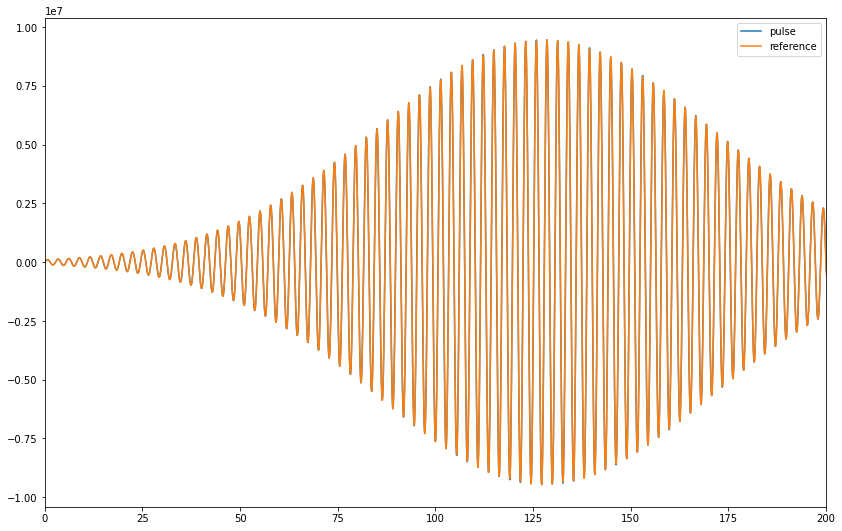

In [13]:
plt.figure(figsize=(14,9))
plt.plot(time,pulse,label='pulse')
plt.plot(ref_time,ref_Ex,label='reference')
plt.legend()
plt.xlim(0,200)

In [14]:
Omega = lambda t : G.gaussianPulse(t,energy=energy,amplitude=pars['Omega0_abs'],fwhm=fwhm,envelope_only=True,verbose=False)

In [15]:
uprime0 = np.array([0.,0.,-1.])

In [16]:
delta = energy - de_cv # in eV
delta_fsm1 = delta/h_red # in fs^-1
delta_fsm1

0.030385348955306226

In [17]:
uprime = TLS.solveBlochEq(uprime0,time,Omega,mu=x_dip,delta=delta_fsm1)

We plot the carriers (rescaled by a factor 2 to be compared with the results of the yambo 
computation that has a spin degeneracy)

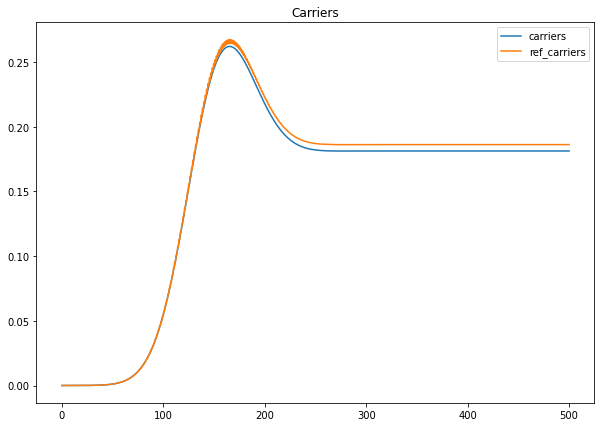

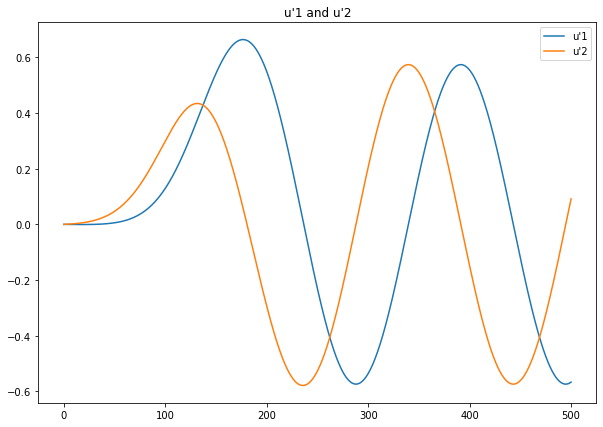

In [18]:
plt.figure(figsize=(10,7))
plt.title('Carriers')
plt.plot(time,(1+uprime[2]),label='carriers')
plt.plot(ref_time,ref_carriers,label='ref_carriers')
plt.legend()
plt.show()

plt.figure(figsize=(10,7))
plt.plot(time,uprime[0],label="u'1")
plt.plot(time,uprime[1],label="u'2")
plt.title("u'1 and u'2")
plt.legend()

We compare the other components of the Bloch vector in the original frame

In [19]:
u = TLS.convertToRotatingFrame(omega,time,uprime,invert=True)

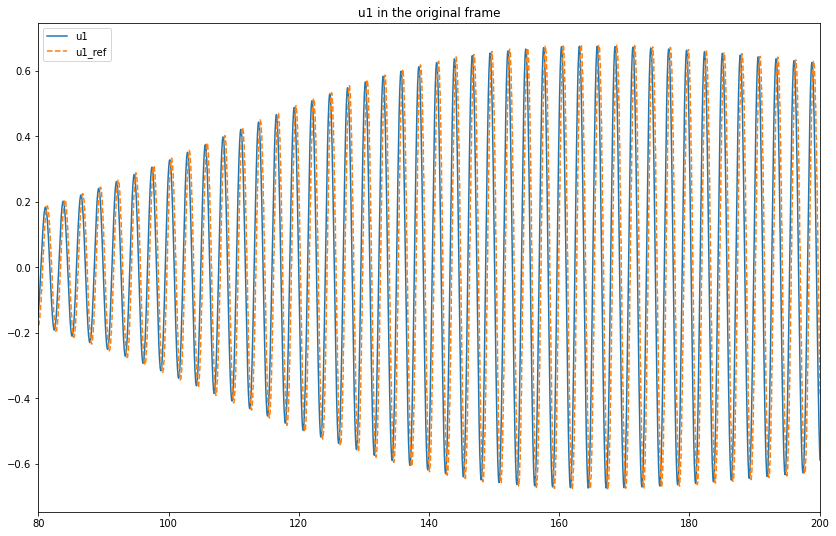

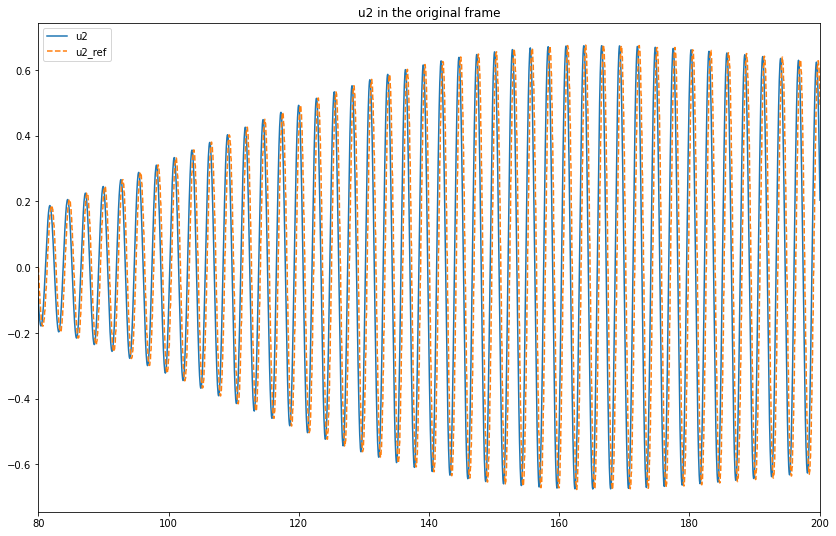

In [20]:
plt.figure(figsize=(14,9))
plt.plot(time,u[0],label='u1')
plt.plot(time,Bloch[0,:,0],linestyle='--',label='u1_ref')
plt.title('u1 in the original frame')
plt.xlim(80,200)
plt.legend()
plt.show()

plt.figure(figsize=(14,9))
plt.plot(time,u[1],label='u2')
plt.plot(time,Bloch[1,:,0],linestyle='--',label='u2_ref')
plt.title('u2 in the original frame')
plt.xlim(80,200)
plt.legend()

The bloch vector built with the TLS is identical to the one extracted from the yambo computation for a single transition.

In [ ]:
##########################################################################################################

### Dynamics in the double pulse configuration

In [26]:
T = 4000 # fs - lenght of the simulation
dt = 0.1 # fs - resolution of time sampling
N = int(T/dt) # number of sampled points
time = np.linspace(0,T,N+1)
T1 = 1000 # delay between the pulses

In [27]:
k_chosen = k_resonant  # 10 is a point with delta = 31.1 meV # 50 is the resonant point with the pump
f1 = field_int_pi2
f2 = field_int_pi

In [28]:
coupl1 = R.eval_pulse_parameters(dipoles[k_chosen],f1,width)[0]
coupl2 = R.eval_pulse_parameters(dipoles[k_chosen],f2,width)[0]
delta = deltas[k_chosen]
print('delta_meV',1e3*delta)
delta_fsm1 = delta/h_red
print('detuning in fs^-1',delta_fsm1)

coupling frequency (THz): 14.756646271360282
pulse area : 1.5707963267948966
coupling frequency (THz): 29.513292542720563
pulse area : 3.141592653589793
delta_meV -0.001962241534148035
detuning in fs^-1 -2.9811696883724824e-06


In [29]:
u0 = [0.,0.,-1.] # initial condition for the system in the gs
Omega_r = lambda t: double_pulse(t,coupl1,width,T1,coupl2)

In [30]:
sol = odeint(Bloch_Eq, u0, time, args=(delta_fsm1, Omega_r))

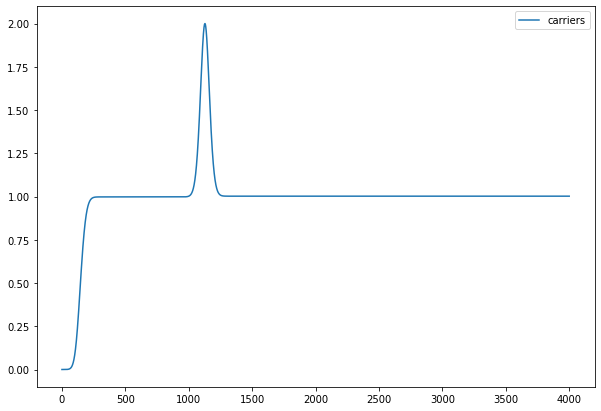

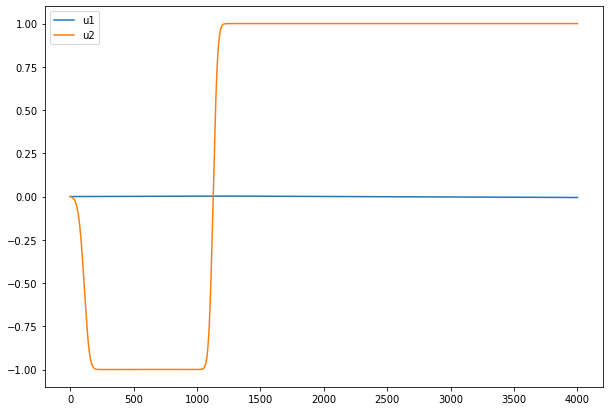

In [31]:
plt.figure(figsize=(10, 7))
#plt.hlines(1.,time[0],time[-1],linestyles='--')
plt.plot(time,1.0*(1+sol[:,2]),label='carriers')
plt.legend(loc='best')
ax2 = ax.twinx()
ax2.plot(time,Omega_r(time)**2,c='red')
ax2.set_ylim(0,0.003)

plt.figure(figsize=(10, 7))
plt.plot(time,sol[:,0],label='u1')
plt.plot(time,sol[:,1],label='u2')
plt.legend(loc='best')

We can reformulate the $u_1$ and $u_2$ components in the original frame

In [32]:
omega = pump_energy/h_red

In [33]:
u1_of = np.cos(omega*time)*sol[:,0] - np.sin(omega*time)*sol[:,1]
u2_of = np.sin(omega*time)*sol[:,0] + np.cos(omega*time)*sol[:,1]

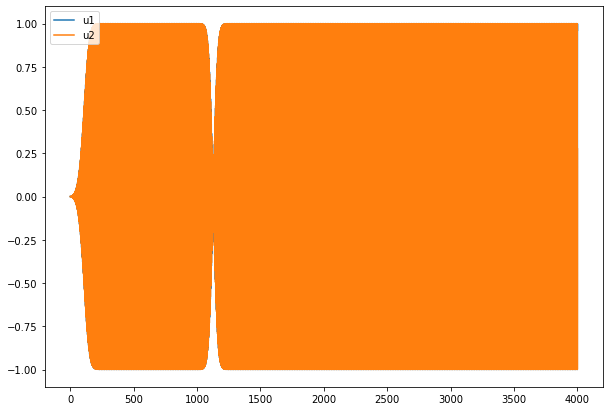

In [34]:
plt.figure(figsize=(10, 7))
plt.plot(time,u1_of,label='u1')
plt.plot(time,u2_of,label='u2')
plt.legend(loc='best')

### Global dynamics in the single pulse configuration

In [35]:
T = 1000 # fs - lenght of the simulation
dt = 0.1 # fs - resolution of time sampling
N = int(T/dt) # number of sampled points
time = np.linspace(0,T,N+1)

In [36]:
f = field_int_pi2

In [37]:
coupl_freqs = []
for k in range(len(dipoles)):
    coupl_freqs.append(R.eval_pulse_parameters(dipoles[k],f,width,verbose=False)[0])
coupl_freqs = np.array(coupl_freqs)

In [38]:
u0 = [0.,0.,-1.] # initial condition for the system in the gs
solutions = []
for k in range(nkpoints):
    delta_fsm1 = deltas[k]/h_red
    Omega_r = lambda t: single_pulse(t,coupl_freqs[k],width)
    solutions.append(odeint(Bloch_Eq, u0, time, args=(delta_fsm1, Omega_r)))

In [39]:
u_global = [0.,0.,0.]
u1, u2, carr = 0.,0.,0.
for sol in solutions:
    u1 += sol[:,0]
    u2 += sol[:,1]
    carr += (1.+sol[:,2]) # include spin degeneration
u_global = [u1/len(deltas),u2/len(deltas),carr/len(deltas)]

carriers 0.2330971441577445


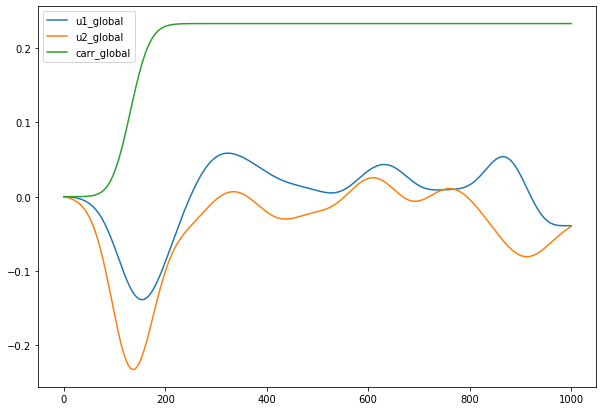

In [40]:
plt.figure(figsize=(10, 7))
plt.plot(time,u_global[0],label='u1_global')
plt.plot(time,u_global[1],label='u2_global')
plt.plot(time,u_global[2],label='carr_global')
plt.legend()
print('carriers',u_global[2][-1])

We can reformulate the $u_1$ and $u_2$ components in the original frame

In [41]:
omega = pump_energy*2.*np.pi/(U.Planck_ev_ps*1e3)

In [42]:
u1_of = np.cos(omega*time)*u_global[0] - np.sin(omega*time)*u_global[1]
u2_of = np.sin(omega*time)*u_global[0] + np.cos(omega*time)*u_global[1]

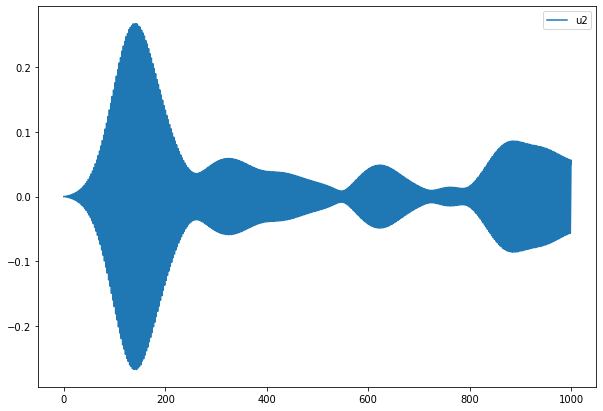

In [43]:
plt.figure(figsize=(10, 7))
#plt.plot(time,u1_of,label='u1')
plt.plot(time,u2_of,label='u2')
plt.legend(loc='best')

### Global dynamics in the double pulse configuration. Echo mechanism

In [44]:
T = 4000 # fs - lenght of the simulation
dt = 0.1 # fs - resolution of time sampling
N = int(T/dt) # number of sampled points
time = np.linspace(0,T,N+1)
T1 = 1000 # delay between the pulses

In [45]:
coupl_freqs1 = []
coupl_freqs2 = []
for k in range(len(dipoles)):
    coupl_freqs1.append(R.eval_pulse_parameters(dipoles[k],field_int_pi2,width,verbose=False)[0])
    coupl_freqs2.append(R.eval_pulse_parameters(dipoles[k],field_int_pi,width,verbose=False)[0])
coupl_freqs1 = np.array(coupl_freqs1)
coupl_freqs2 = np.array(coupl_freqs2)

In [46]:
u0 = [0.,0.,-1.] # initial condition for the system in the gs
solutions = []
for k in range(nkpoints):
    delta_fsm1 = deltas[k]/h_red
    Omega_r = lambda t: double_pulse(t,coupl_freqs1[k],width,T1,
                                 coupl_freqs2[k])
    solutions.append(odeint(Bloch_Eq, u0, time, args=(delta_fsm1, Omega_r)))

In [47]:
u_global = [0.,0.,0.]
u1, u2, carr = 0.,0.,0.
for sol in solutions:
    u1 += sol[:,0]
    u2 += sol[:,1]
    carr += (1.+sol[:,2]) # include spin degeneration
u_global = [u1/len(deltas),u2/len(deltas),carr/len(deltas)]

carriers 0.3883412820626765


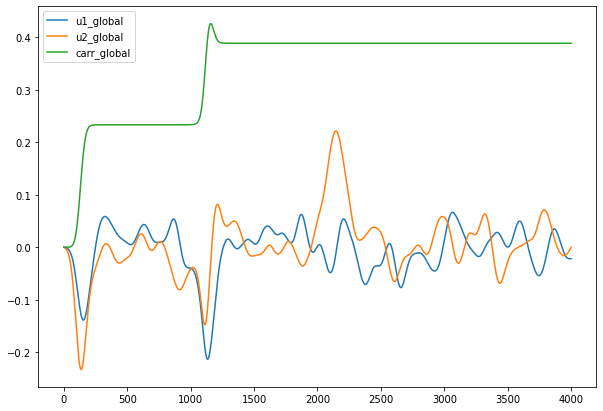

In [48]:
plt.figure(figsize=(10, 7))
plt.plot(time,u_global[0],label='u1_global')
plt.plot(time,u_global[1],label='u2_global')
plt.plot(time,u_global[2],label='carr_global')
plt.legend()
print('carriers',u_global[2][-1])

We can reformulate the $u_1$ and $u_2$ components in the original frame

In [53]:
omega = pump_energy/h_red

In [54]:
u1_of = np.cos(omega*time)*u_global[0] - np.sin(omega*time)*u_global[1]
u2_of = np.sin(omega*time)*u_global[0] + np.cos(omega*time)*u_global[1]

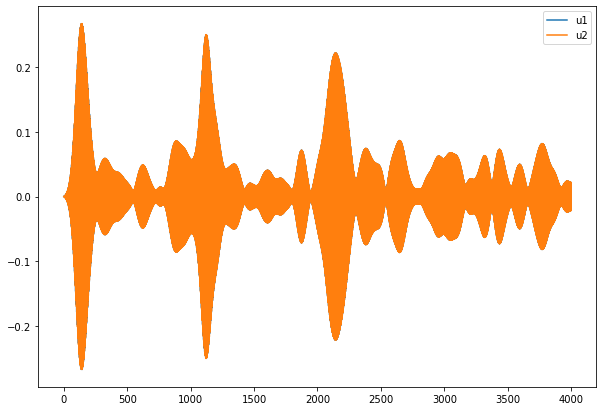

In [55]:
plt.figure(figsize=(10, 7))
plt.plot(time,u1_of,label='u1')
plt.plot(time,u2_of,label='u2')
plt.legend(loc='best')

## TLS Analysis of GaAs (with optimal selection of the leading transition for each $k$-point)

.....TO BE UPDATED.....

We repeat the previous analysis with the improvement of selecting the leading transition for each $k$-point

In [25]:
def Bloch_Eq(u, t, delta, Omega_r):
    dudt = [delta*u[1], -delta*u[0]+Omega_r(t)*u[2],-Omega_r(t)*u[1]]
    return dudt

We study the FID and the echo mechanism using the transition dipoles and transition energies of the GaAs. 

We consider only the transition from the highest occupied bands to the lowest conduction
state, so that for each $k$-point the system behaves like a true TLS

In [26]:
scissor = 0.9548 # (eV) (taken from QE_Analysis it gives a direct gap of 1.42 eV)
width = 42.46609 # the field width in fs
pump_energy = 1.5 # eV
h = U.Planck_ev_ps*1e3 # Planck constant in ev*fs
h_red = U.Planck_ev_ps*1e3/(2*np.pi) # Reduced Planck constant in ev*fs

In [4]:
ndb_path = 'PHOTON_ECO/RT_k100_kspan0.04/FixSymm/eta_1e-05-field_eng_1.5-field_int_23758-sim_time_1000'
ndb = os.path.join(ndb_path,'ndb.dipoles')
save = 'PHOTON_ECO/RT_k100_kspan0.04/FixSymm/SAVE'
nkpoints = 1182

We build a dictionary that for each $k$-point contains the all the possible transition from ''valence'' to conduction states

In [27]:
dipoles_v1c = []
dipoles_v2c = []
dipoles_v3c = []

energies_v1c = []
energies_v2c = []
energies_v3c = []
for k in range(nkpoints):
    dipoles_v1c.append(R.eval_transition_dipole(ndb,kpoint=k,transition=[2,3]))
    energies_v1c.append(R.eval_trans_energy(save,kpoint=k,transition=[3,4],set_scissor=scissor))
    dipoles_v2c.append(R.eval_transition_dipole(ndb,kpoint=k,transition=[1,3]))
    energies_v2c.append(R.eval_trans_energy(save,kpoint=k,transition=[2,4],set_scissor=scissor))
    dipoles_v3c.append(R.eval_transition_dipole(ndb,kpoint=k,transition=[0,3]))
    energies_v3c.append(R.eval_trans_energy(save,kpoint=k,transition=[1,4],set_scissor=scissor))

transitions = {
    'v1c' : {'dipoles' : dipoles_v1c, 'energies' : energies_v1c},
    'v2c' : {'dipoles' : dipoles_v2c, 'energies' : energies_v2c},
    'v3c' : {'dipoles' : dipoles_v3c, 'energies' : energies_v3c}
}

We select the transition closest to the pump for each k point

In [28]:
select_transitions = []
trans_label = ['v1c','v2c','v3c']
for k in range(nkpoints):
    delta_trans = []
    for t in trans_label:
        delta_trans.append(pump_energy-transitions[t]['energies'][k])
    delta_trans = np.array(delta_trans)
    abs_trans = abs(delta_trans)
    select_transitions.append(trans_label[abs_trans.argmin()])

We choose the field intensity that for the $k$-point resonant with the pump energy gives the $\pi/2$ configuration

In [29]:
field_int_pi2 = 23758
field_int_pi = 95033
field_int_hi = 2e5

In [30]:
def eval_coupling_frequencies(field_int):
    coupling_frequencies = []
    Z0 = U.vacuum_impedence
    field_int = field_int*1e3*1e4 #W/m^2
    field_amp = np.sqrt(Z0*field_int) #V/m
    field_amp = field_amp*U.Bohr_radius #V/a0 in atomic units

    for k in range(nkpoints):
        dip = transitions[select_transitions[k]]['dipoles'][k]
        dip_mod = np.sqrt(dip[0]**2 + dip[1]**2)
        coupling_frequency = dip_mod*field_amp/h_red # om fs^-1  
        coupling_frequencies.append(coupling_frequency)
    return np.array(coupling_frequencies)

In [31]:
deltas = []
for k in range(nkpoints):
    deltas.append(pump_energy-transitions[select_transitions[k]]['energies'][k])

In [32]:
def single_pulse(t,A,width):
    t0 = 3*width
    return A*np.exp(-(t-t0)**2/(2.*width**2))

def double_pulse(t,A1,width,T1,A2):
    t0 = 3*width
    pulse1 = A1*np.exp(-(t-t0)**2/(2.*width**2))
    pulse2 = A2*np.exp(-(t-(t0+T1))**2/(2.*width**2))
    return pulse1 + pulse2

### Global dynamics in the single pulse configuration

In [33]:
T = 1000 # fs - lenght of the simulation
dt = 0.1 # fs - resolution of time sampling
N = int(T/dt) # number of sampled points
time = np.linspace(0,T,N+1)

In [34]:
f = field_int_pi2

In [35]:
u0 = [0.,0.,-1.] # initial condition for the system in the gs
solutions = []
coupl_freq = eval_coupling_frequencies(f)
for k in range(nkpoints):
    delta_fsm1 = deltas[k]/h_red
    Omega_r = lambda t: single_pulse(t,coupl_freq[k],width)
    solutions.append(odeint(Bloch_Eq, u0, time, args=(delta_fsm1, Omega_r)))

In [36]:
u_global = [0.,0.,0.]
u1, u2, carr = 0.,0.,0.
for sol in solutions:
    u1 += sol[:,0]
    u2 += sol[:,1]
    carr += (1.+sol[:,2]) # include spin degeneration
u_global = [u1/len(deltas),u2/len(deltas),carr/len(deltas)]

carriers 0.30697756826734235


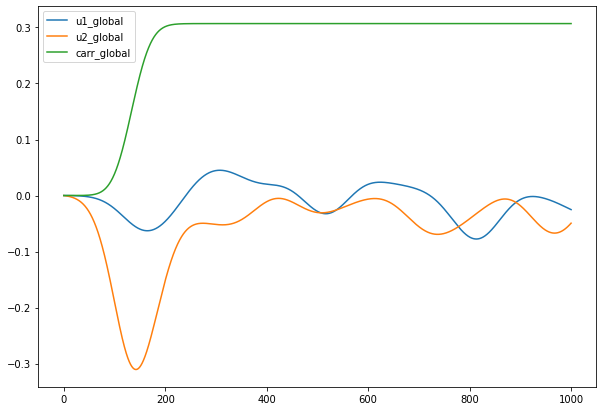

In [37]:
fig, ax = plt.subplots(figsize=(10, 7))
plt.plot(time,u_global[0],label='u1_global')
plt.plot(time,u_global[1],label='u2_global')
plt.plot(time,u_global[2],label='carr_global')
plt.legend()
print('carriers',u_global[2][-1])

We can reformulate the $u_1$ and $u_2$ components in the original frame

In [38]:
omega = pump_energy*2.*np.pi/(U.Planck_ev_ps*1e3)

In [39]:
u1_of = np.cos(omega*time)*u_global[0] - np.sin(omega*time)*u_global[1]
u2_of = np.sin(omega*time)*u_global[0] + np.cos(omega*time)*u_global[1]

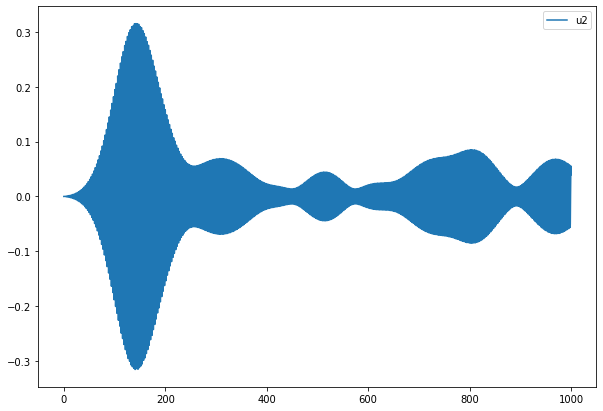

In [40]:
fig, ax = plt.subplots(figsize=(10, 7))
#plt.plot(time,u1_of,label='u1')
plt.plot(time,u2_of,label='u2')
plt.legend(loc='best')

### Global dynamics in the double pulse configuration. Echo mechanism

In [41]:
T = 4000 # fs - lenght of the simulation
dt = 0.1 # fs - resolution of time sampling
N = int(T/dt) # number of sampled points
time = np.linspace(0,T,N+1)
T1 = 1000 # delay between the pulses

In [42]:
u0 = [0.,0.,-1.] # initial condition for the system in the gs
solutions = []
coupl_freq_pi2 = eval_coupling_frequencies(field_int_pi2)
coupl_freq_pi = eval_coupling_frequencies(field_int_pi)
for k in range(nkpoints):
    delta_fsm1 = deltas[k]/h_red
    Omega_r = lambda t: double_pulse(t,coupl_freq_pi2[k],width,T1,
                                 coupl_freq_pi[k])
    solutions.append(odeint(Bloch_Eq, u0, time, args=(delta_fsm1, Omega_r)))

In [43]:
u_global = [0.,0.,0.]
u1, u2, carr = 0.,0.,0.
for sol in solutions:
    u1 += sol[:,0]
    u2 += sol[:,1]
    carr += (1.+sol[:,2]) # include spin degeneration
u_global = [u1/len(deltas),u2/len(deltas),carr/len(deltas)]

carriers 0.49034464053190707


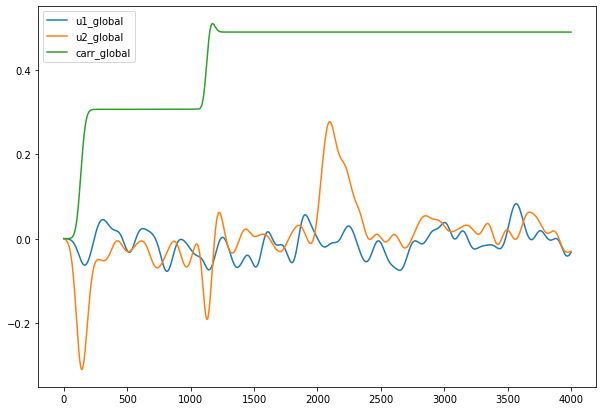

In [44]:
fig, ax = plt.subplots(figsize=(10, 7))
plt.plot(time,u_global[0],label='u1_global')
plt.plot(time,u_global[1],label='u2_global')
plt.plot(time,u_global[2],label='carr_global')
plt.legend()
print('carriers',u_global[2][-1])

We can reformulate the $u_1$ and $u_2$ components in the original frame

In [45]:
omega = pump_energy*2.*np.pi/(U.Planck_ev_ps*1e3)

In [46]:
u1_of = np.cos(omega*time)*u_global[0] - np.sin(omega*time)*u_global[1]
u2_of = np.sin(omega*time)*u_global[0] + np.cos(omega*time)*u_global[1]

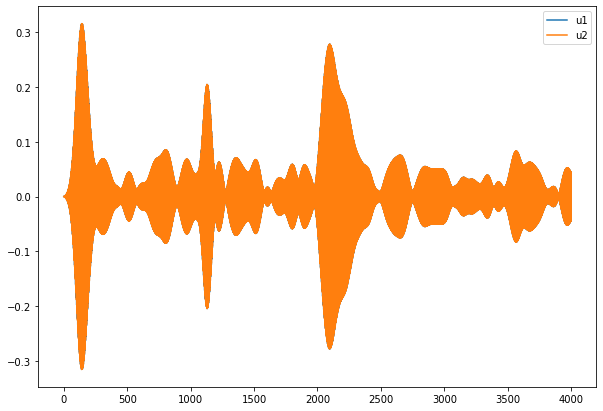

In [47]:
fig, ax = plt.subplots(figsize=(10, 7))
plt.plot(time,u1_of,label='u1')
plt.plot(time,u2_of,label='u2')
plt.legend(loc='best')

In [ ]:
################################################################################################

# TLS description of optical absorption

In this notebook we present a two level system (TLS) based description of optical absorption. We analyze the
construction of the _Bloch vector_ representation of the model and we discuss the topics needed to deal with the
photon eco mechanisms.

The Hamiltonian of the system is represented as
$$
H = \frac{1}{2}\omega_0 \sigma_z \, , 
$$
where $\sigma_z$ is the Pauli matrix. $H$ is diagonal in the chosen representation with a energy shift 
between the two levels given by  $\omega_0$. The eigenstates are represented as
$$
|1\rangle = \left(\begin{array}{c}
1\\
0\\
\end{array} \right) \, , \quad
|2\rangle = \left(\begin{array}{c}
0\\
1\\
\end{array} \right) \, .
$$
Note that in this notation $|2\rangle$ describe the GS of the system, while $|1\rangle$ is the excited state.

The interaction of the optical pump with the system is described by an Hamiltonian $H^I$ that has only non-diagonal 
non vanishing matrix elements. 

The equation of motion (EQM) of the density matrix (DM) are expressed by the Liouville equation
$$
i \dot{\rho} = \left[H+H^I,\rho\right]
$$
and we can explicitly write the associated equations for the matrix elements of the DM in the chosen basis using
the structure of both the Hamitonian defined above. We obtain:
$$
i \dot{\rho}_{11} = H^I_{12}\rho_{21} - H^I_{21}\rho_{12} \\
i \dot{\rho}_{22} = H^I_{21}\rho_{12} - H^I_{12}\rho_{21} \\
i \dot{\rho}_{12} = \omega_0\rho_{12} + H^I_{12}(\rho_{22}-\rho_{11}) \\
i \dot{\rho}_{21} = -\omega_0\rho_{21} - H^I_{21}(\rho_{22}-\rho_{11})
$$
where $H^I_{12} = \langle 1|H^I|2\rangle$ and $H^I_{21} = \langle 2|H^I|1\rangle$, furthermore
$H^I_{12} = H^{I*}_{21}$ since $H^I$ is hermitian. These equations imply that $\rho_{21}$ is the complex
conjugate of $\rho_{12}$ and that $\rho_{11}+\rho_{22}$ is constant, that is the conservation of the charge.

## Interaction Hamiltonian and rotating wave approximation (RWA)

We consider an interaction between the system and the optical pump described by a dipole interaction, that is
$$
H^I = - \mathbf{\mu}\cdot\mathbf{E}(t)
$$
where $\mathbf{\mu}$ is the dipole operator. We choose a linear polarized electric field (along an arbitrary chosen axis).
The time dependece of the field is described by a monocromatic wave of energy $\omega$ times a real slow enevelope function $E_0(t)$.
Due to this assumption the matrix element $H^I_{12}$ can be expressed as
$$
H^I_{12} = - \mu E_0(t) cos(\omega t) \doteq - \Omega_r(t) cos(\omega t)
$$
Here $\mu$ is matrix element of the component of the dipole parallel to $\mathbf{E}$ evaluated between the states 1 and 2 and
we have introduced the (time-dependent) _Rabi frequency_ $\Omega_r$. In this analysis we asssume that the Rabi frequency is real,
further investigation on this point will be performed later.

We are interested in probing the system with energy of the pump not very different from the energy gap of the system, that is if we introduce 
the energy shift $\delta$ as
$$
\omega = \omega_0 + \delta
$$
the condition $\delta \ll \omega_0$ is sastisfied. This fact allows us to introduce the rotating wave approximation. To understand this point
consider that, for instance, the generic solution for $\rho_{12}$ can be written as
$$
\rho_{12} = Ae^{-i\omega_0t} + e^{-i\omega_0t}\int_{t_0}^{t}dt'e^{i\omega_0t'}\Omega_r(t')cos(\omega t')
\left(\rho_{22}-\rho_{11}\right)
$$
Due to the presence of the factor $e^{i\omega_0 t'}$ in the integral the cosine can be splitted into complex exponentials and only the
addend $e^{-i\omega t'}$ gives relevant contributions since the fast oscillating terms cancel. So the interaction matrix element in the RWA
read
$$
H^I_{12} = - \frac{1}{2} \Omega_r(t)e^{-i\omega t}
$$

Note that this argument is usually discussed and justified for __constant__ Rabi frequency, however if the envelope function $E_0(t)$ is slow we can split the previous integral into various terms in 
which the frequency is constant and apply the same argument to all the addends.

## Bloch vector representation

The DM is an hermitian operator that satisfy the condition $Tr(\rho)$ = 1. So it can be represented as
$$
\rho = \frac{1}{2}\left(1+\mathbf{u}\cdot\mathbf{\sigma}\right)
$$
The parameters $\mathbf{u}$ are the Bloch vector components associated to the DM and thanks
to the properties of the traces of the Pauli matrices can be extracted as $u_{i} = Tr(\rho\sigma_i)$.
In terms of the matrix elements of the DM the Bloch components read
$$
u_1 = 2Re(\rho_{12}) \, , \quad
u_2 = - 2Im(\rho_{12}) = 2Im(\rho_{21})  \, , \quad
u_3 = \rho_{11}-\rho_{22}
$$

We can derive the EQM for the $u_i$ using their definition, for instance from the equation for $\rho_{12}$ we have
$$
i\left(\dot{u}_1- i \dot{u}_2\right) = \omega_0 \left(u_1-iu_2 \right)
-2 \left( Re(H^I_{12}) + i Im(H^I_{12}) \right) u_3
$$
and from the ones for $\rho_{11}$ and $\rho_{22}$ we have
$$
i\dot{u}_3 = 2 H^I_{12}\rho_{21} - 2H^{I}_{21}\rho_{12} = 
H^I_{12}\left(u_1+iu_2 \right) - H^{I}_{21} \left(u_1-iu_2 \right)
$$
so isolating the real and the imaginary parts give the equations for the $u_i$
$$
\dot{u}_1 = -\omega_0 u_2 - 2Im(H^I_{12})u_3 \\
\dot{u}_2 = \omega_0 u_1 - 2Re(H^I_{12})u_3 \\
\dot{u}_3 = 2Im(H^I_{12})u_1+ 2Re(H^I_{12})u_2
$$

## Formulation in the rotating frame (RF)

The usage of the RWA allows us to express the Bloch vector into a properly chose rotating frame (RF) in which the $u_1$ and $u_2$ components
are rotated with the frequency of the pump. In this frame the equations are simpler since the fast fluctuation of energy $\omega_0$ disappear. 

The transformation that moves to the RF is
$$
\mathbf{u}' = \Theta \cdot \mathbf{u} \, , \,\,\, with \quad
\Theta = \left(\begin{array}{ccc}
cos(\omega t) & sin(\omega t) & 0\\
-sin(\omega t) & cos(\omega t) & 0\\
0 & 0 & 1
\end{array} \right)
$$

With some algebra the EOM in this frame read
$$
\dot{u}'_1 = \left(\omega-\omega_0\right)u'_2  = \delta u'_2 \\
\dot{u}'_2 = \left(\omega_0-\omega\right)u'_1 + \Omega_r u'_3 = -\delta u'_1 + \Omega_r u'_3 \\
\dot{u}'_3 = -\Omega_r u'_2
$$
and we observe that the only parameters in this frame are the detuning $\delta$ and the Rabi frequency.

Note that in this derivation of the previous equation $\Omega_r$ can be a (slowly varying) function of time, so the
relevant case of one or several pulse with gaussian profile can be treated within the present formalism.

## Representation of the polarization and of the number of carriers

It is useful to express some observables like the polarization or the density of charge in the excited states in this formalism. 
These quantities can be compared with the results provided by the abinitio real time simulations.

Assuming that the only non vanishing matrix elements of the position operator (say $x$ component) are the non diagonal ones we have
$$
P = x_{12}\rho_{12} + x_{21}\rho_{21}
$$
that can be expressed in the terms of the components of the Bloch vector as
$$
P = u_1 Re(x_{12}) + u_2 Im(x_{12})
$$
So we observe that the elemnts $u_1$ and $u_2$ are responsible for the behavior of the polarization.

Instead the density of charge in the excited state is given by $\rho_{11}$ that, using the condition $\rho_{11}+\rho_{22} = 1$
can be expressed as
$$
\rho_{11} = \frac{1+u_3}{2}
$$

## Analytic solution for constant field

We seek for the general solution of the EQM in the RF for a constant field $\Omega_r$. In what follows we omit the 
apex on the $u_i$ components. We start from a guess for $u_1$ of the form
$$
u_1(t) = Asin(\Delta t) + Bcos(\Delta t) + C \,\,\, , with \quad
\Delta = \sqrt{\delta^2+\Omega_r^2}
$$
the constants $A,B,C$ will be determined imposing the boundary conditions for $u_i$. Plugging this guess in the EQM for $u_1$
we obtain
$$
u_2(t) = \frac{A\Delta}{\delta}cos(\Delta t) - \frac{B\Delta}{\delta}sin(\Delta t)
$$
and pluggin this expression in the EQM for $u_2$ allows us to derive the expression of $u_3$ 
$$
u_3(t) = -\frac{A\Omega_r}{\delta}sin(\Delta t) -\frac{B\Omega_r}{\delta}cos(\Delta t) +\frac{C\delta}{\Omega_r}
$$
pluggin this expression in the EQM for $u_3$ we obtain $-\Omega_r u_2(t)$ as expected, so the guess is correct.

The constants are determined through the boundary conditions
$$
u_1^0 = B+C \, , \quad
u_2^0 = \frac{A\Delta}{\delta} \, , \quad
u_3^0 = -\frac{B\Omega_r}{\delta} +\frac{C\delta}{\Omega_r}
$$
and their solution reads
$$
A = \frac{\delta}{\Delta}u_2^0 \, , \quad
B = \frac{\delta^2}{\Delta^2}u_1^0 - \frac{\delta\Omega_r}{\Delta^2}u_3^0 \, , \quad
C = \frac{\Omega_r^2}{\Delta^2}u_1^0 + \frac{\delta\Omega_r}{\Delta^2}u_3^0
$$

It is useful to plug these expressions in the ones for the $u_i$ to obtain the general result (Note that this is specially needed if $\delta=0$ since in this 
case some factors vanish and other diverge)
$$
u_1(t) = \frac{\delta}{\Delta}u_2^0 sin(\Delta t) + 
\left(\frac{\delta^2}{\Delta^2}u_1^0 - \frac{\delta\Omega_r}{\Delta^2}u_3^0\right)cos(\Delta t) + 
\left( \frac{\Omega_r^2}{\Delta^2}u_1^0 + \frac{\delta\Omega_r}{\Delta^2}u_3^0 \right)\\
u_2(t) = u_2^0cos(\Delta t) - 
\left( \frac{\delta}{\Delta}u_1^0 - \frac{\Omega_r}{\Delta}u_3^0\right) sin(\Delta t) \\
u_3(t) = - \frac{\Omega_r}{\Delta}u_2^0sin(\Delta t) -
\left( \frac{\delta\Omega_r}{\Delta^2}u_1^0 - \frac{\Omega_r^2}{\Delta^2}u_3^0\right)cos(\Delta t) +
\left( \frac{\delta\Omega_r}{\Delta^2}u_1^0 + \frac{\delta^2}{\Delta^2}u_3^0\right)
$$

### Solutions for zero field $\Omega_r = 0$

In this case $\Delta=\delta$, and the general solution reduces to
$$
u_1(t) = u_1^0cos(\delta t) + u_2^0sin(\delta t)  \\
u_2(t) = - u_1^0sin(\delta t) +u_2^0cos(\delta t)   \\
u_3(t) = u_3^0
$$

## Analytic solution for time-dependent field for $\delta=0$

For $\delta=0$ the solution can be parametrized like in the time-dependent case. The only modification
is that the argument of the sine and cosine function becomes 
$$
\theta(t) = \int_0^t dt' \Omega_r(t')
$$
We observe that $\dot{\theta}(t) = \Omega_r(t)$ and so the $u_i$ written in terms of $\theta(t)$ satisfy the correct EQM with
a time-dependent Rabi frequency.

$$
u_1(t) = u_1^0 \\
u_2(t) = u_2^0cos(\theta(t))  + u_3^0sin(\theta(t)) \\
u_3(t) = - u_2^0sin(\theta(t)) + u_3^0cos(\theta(t))
$$


On the basis of these equations we see that the area of the pulse 
$$
\theta =  \int_{-\infty}^{\infty} dt' \Omega_r(t') 
$$
is the object that realizes the $\pi/2$ or the $\pi$ conditions:
 * $\theta=\pi/2$ :  the system initially in the ground state $u^0=(0,0,-1)$ reach the state with $u_2=-1$ and $u_3=0$, that correspond to an occupation level of the excited state equal to $1/2$.
 * $\theta=\pi$ : the Bloch vector changes sign. If the system starts from the ground state the occupation level of the excited state is maximum.
 
If $\Omega_r$ is parametrized as
$$
\Omega_r = Ae^{-\frac{1}{2}\left(\frac{t-t_0}{w}\right)^2}
$$
the $n\pi$ condition becomes
$$
\sqrt{2}wA = n\sqrt{\pi}
$$